
# Actor–Critic

- **Actor (política)**: modelo que produce una distribución de probabilidad sobre acciones `π(a|s)`.
- **Critic (valor)**: modelo que estima el valor del estado `V(s)` para reducir la varianza del gradiente.
- **Ventaja (advantage)**: `A(s,a) = G_t - V(s_t)`, mide qué tan buena fue la acción comparada con lo esperado.
- **Retorno (return)**: suma de recompensas que usamos como objetivo del Critic.


In [1]:
import math
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque
import pandas as pd
import seaborn as sns

In [2]:
env_name = "CartPole-v1"
env = gym.make(env_name)

# Actor-Critic


## Arquitectura `ActorCritic`

- **Crítico (`self.critic`)**: estima `V(s)` (valor del estado). Se usa para **bootstrapping** y para calcular la **ventaja**.
- **Actor (`self.actor`)**: produce **logits** o **probabilidades** sobre las acciones. Con los logits usamos `Categorical(logits=...)` para mayor estabilidad numérica, y dejamos que la distribución aplique la softmax internamente.        

In [13]:
# Clase ActorCritic: separa Actor (política) y Critic (valor).
class ActorCritic(nn.Module): 
    def __init__(self, n_inputs, n_outputs, hidden_size, std=0.0):  # Corregido: __init__
        super(ActorCritic, self).__init__() 
        self.critic = nn.Sequential(
            nn.Linear(n_inputs, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.actor = nn.Sequential(
            nn.Linear(n_inputs, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, n_outputs)
        )
    
    def forward(self, x): 
        value = self.critic(x)
        probs = self.actor(x)
        dist = Categorical(logits=probs)
        return dist, value.squeeze(-1)


## Función `compute_returns`

Calcula los **retornos** (targets para el crítico) con **bootstrap** usando `V(s_{t+1})`. Usualmente:
\[ G_t = r_t + \gamma \cdot \text{mask}_t \cdot G_{t+1} \]
donde `mask_t = 0` al terminar el episodio para **cortar** la propagación del retorno.


## Muestreo de acciones desde la política

`dist.sample()` obtiene una acción estocástica según `π(a|s)`.  
Esta estocasticidad fomenta la **exploración**. En evaluación, podrías usar `dist.probs.argmax()` para una política **greedy**.

**Nota:** para entornos discretos, convierte la acción a `int` antes de `env.step(...)`.
        

In [14]:
class ObsNorm:
    def __init__(self, eps=1e-8):  # Corregido: __init__
        self.count = 0
        self.mean = None
        self.var  = None
        self.eps  = eps
    
    def update(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.flatten()
        if self.mean is None:
            self.mean = x.clone()
            self.var  = torch.ones_like(x)
            self.count = 1
            return
        self.count += 1
        delta = x - self.mean
        self.mean += delta / self.count
        self.var  += delta * (x - self.mean)
    
    def normalize(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        x = x.flatten()
        std = torch.sqrt(self.var / max(self.count-1, 1) + self.eps)
        return (x - self.mean) / std


obs_norm = ObsNorm()

In [5]:
# dist.sample(): muestrea acciones para explorar.
# En evaluación, usar la acción más probable si se desea comportamiento determinista.
# compute_returns: implementa el bootstrapping con V(s_{t+1}) y máscaras.
import matplotlib.pyplot as plt 
from IPython.display import clear_output

def compute_returns_gae(next_value, rewards, masks, values, gamma=0.99, lam=0.95):
    """
    rewards, masks, values: tensores 1D de longitud T
    next_value: escalar 1D (valor del estado posterior al último paso)
    Devuelve: returns (T), advantages (T)
    """
    T = len(rewards)
    returns = torch.zeros(T, dtype=torch.float32)
    adv = torch.zeros(T, dtype=torch.float32)

    gae = 0.0
    for t in reversed(range(T)):
        v_next = next_value if t == T-1 else values[t+1]
        delta = rewards[t] + gamma * v_next * masks[t] - values[t]
        gae = delta + gamma * lam * masks[t] * gae
        adv[t] = gae
        returns[t] = adv[t] + values[t]
    return returns, adv

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [15]:
def test_env(vis=False, model=None):
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        dist, _ = model(state)
        # Usar argmax para evaluación determinista
        next_state, reward, terminated, truncated, _ = env.step(int(dist.probs.argmax(dim=-1)))
        done = np.logical_or(terminated, truncated)
        state = next_state
        total_reward += reward
    return total_reward

In [7]:
# --- NUEVO: utilidades de graficado ---
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Exponencial Moving Average para suavizar (opcional)
def ema(x, alpha=0.1):
    if len(x) == 0:
        return []
    y = [x[0]]
    for t in range(1, len(x)):
        y.append(alpha * x[t] + (1 - alpha) * y[-1])
    return y

def plot_losses(frames_hist, actor_hist, critic_hist, total_hist, use_ema=True):
    clear_output(wait=True)
    plt.figure(figsize=(8,4))
    if use_ema:
        plt.plot(frames_hist, ema(actor_hist), label='Actor loss (EMA)')
        plt.plot(frames_hist, ema(critic_hist), label='Critic loss (EMA)')
        plt.plot(frames_hist, ema(total_hist), label='Total loss (EMA)')
    else:
        plt.plot(frames_hist, actor_hist, label='Actor loss')
        plt.plot(frames_hist, critic_hist, label='Critic loss')
        plt.plot(frames_hist, total_hist, label='Total loss')
    plt.xlabel('Frames')
    plt.ylabel('Loss')
    plt.title('Evolución de pérdidas: Actor / Critic / Total')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n 
hidden_size = 128


In [9]:
print(f"{n_inputs} - {n_outputs} - {hidden_size}")

4 - 2 - 128



## Muestreo de acciones desde la política

`dist.sample()` obtiene una acción estocástica según `π(a|s)`.  
Esta estocasticidad fomenta la **exploración**. En evaluación, podrían usar `dist.probs.argmax()` para una política **greedy**.

        


## Ventaja (Advantage)

La **ventaja** mide cuánto mejor/peor fue la acción respecto a lo esperado por el crítico:
\[ A_t = G_t - V(s_t) \]

**Consejo práctico:**
- Normaliza `A_t` para estabilizar el entrenamiento:
```python
advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
```
        


## Pérdidas del Actor y del Crítico

- **Actor:** maximiza la probabilidad de acciones con `A_t > 0` y minimiza con `A_t < 0`:
\[ L_{actor} = -\mathbb{E}[\log \pi(a_t|s_t) \cdot A_t] \]
  Usamos `advantage.detach()` para **no** retropropagar a través del crítico.

- **Crítico:** se entrena con MSE hacia los retornos:
\[ L_{critic} = \mathbb{E}[(G_t - V(s_t))^2] \]

- **Total:** `loss = L_actor + c_v * L_critic ( - β * H )` donde `H` es entropía (opcional) para promover exploración.
        


## Paso de Optimización

Secuencia típica en PyTorch:
1. `optimizer.zero_grad()` para limpiar gradientes acumulados.
2. `loss.backward()` para calcular gradientes vía backprop.
3. `optimizer.step()` para actualizar parámetros.
        

In [10]:
import torch.nn.functional as F 

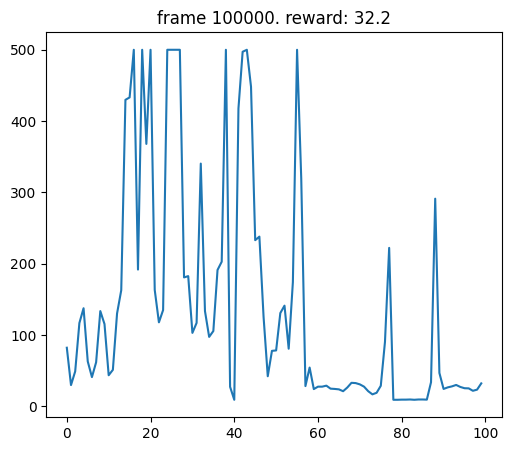

In [ ]:
actor_critic_model = ActorCritic(n_inputs, n_outputs, hidden_size)
optimizer = optim.Adam(actor_critic_model.parameters(), lr = 3e-4)

n_steps = 50
max_frames = 100000

state, _ = env.reset()
obs_norm.update(state)
state = obs_norm.normalize(state)

test_rewards = []
frame_idx = 0

frames_hist  = []
actor_hist   = []
critic_hist  = []
total_hist   = []

while frame_idx < max_frames:
    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0.0
    
    for _ in range(n_steps):
        state_t = torch.as_tensor(state, dtype=torch.float32)
        dist, value = actor_critic_model(state_t)
        action = dist.sample()
        action_np = int(action.item())

        next_state, reward, terminated, truncated, _ = env.step(action_np)
        
        obs_norm.update(next_state)  # Mover aquí la actualización
        next_state = obs_norm.normalize(next_state)
        done = np.logical_or(terminated, truncated)
        
        log_prob = dist.log_prob(action)
        if log_prob.ndim > 1:
            log_prob = log_prob.sum(-1)
        entropy = entropy + dist.entropy().mean() 
        
        log_probs.append(log_prob)
        values.append(value.squeeze(-1))
        rewards.append(torch.as_tensor(reward, dtype=torch.float32))
        masks.append(torch.as_tensor(1.0 - done.astype(np.float32), dtype=torch.float32))
        
        state = next_state
        if done: 
            state, _ = env.reset()
            obs_norm.update(state)
            state = obs_norm.normalize(state) 
        
        frame_idx += 1
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env(model=actor_critic_model) for _ in range(5)]))
            plot(frame_idx, test_rewards)

    # Calcular next_value correctamente
    next_state_t = torch.as_tensor(state, dtype=torch.float32)
    with torch.no_grad():
        _, next_value = actor_critic_model(next_state_t)
    
    # GAE computation
    returns, advantages = compute_returns_gae(next_value, rewards, masks, values, gamma=0.99, lam=0.95)
    
    log_probs = torch.stack(log_probs)
    values    = torch.stack(values)
    
    # Normalizar advantages
    adv_norm = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    # Losses
    actor_loss  = -(log_probs * adv_norm.detach()).mean()
    critic_loss = (returns - values).pow(2).mean()
    loss = actor_loss + 0.5 * critic_loss - 0.05 * (entropy / len(log_probs))
    
    # Optimización
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(actor_critic_model.parameters(), 0.5)
    optimizer.step()
    
    # Registro de métricas
    frames_hist.append(frame_idx)
    actor_hist.append(actor_loss.item())
    critic_hist.append(critic_loss.item())
    total_hist.append(loss.item())

# FUNCIONES ADICIONALES PARA DIFERENTES LOSS FUNCTIONS

def train_with_different_losses():
    """
    Experimenta con diferentes funciones de pérdida para el Critic
    """
    loss_functions = {
        'MSE': lambda pred, target: F.mse_loss(pred, target),
        'Huber': lambda pred, target: F.smooth_l1_loss(pred, target),
        'MAE': lambda pred, target: F.l1_loss(pred, target)
    }
    
    results = {}
    
    for loss_name, loss_fn in loss_functions.items():
        print(f"\nEntrenando con {loss_name} Loss...")
        
        # Reinicializar modelo
        model = ActorCritic(n_inputs, n_outputs, hidden_size)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)
        
        # Evaluar
        final_reward = np.mean([test_env(model=model) for _ in range(10)])
        results[loss_name] = final_reward
        print(f"{loss_name} - Reward final: {final_reward:.2f}")
    
    return results

# Graficar
def plot_losses_improved(frames_hist, actor_hist, critic_hist, total_hist, use_ema=True):
    """
    Versión mejorada del graficado con más información
    """
    clear_output(wait=True)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    if use_ema:
        actor_smooth = ema(actor_hist)
        critic_smooth = ema(critic_hist)
        total_smooth = ema(total_hist)
    else:
        actor_smooth = actor_hist
        critic_smooth = critic_hist
        total_smooth = total_hist
    
    # Losses individuales
    axes[0, 0].plot(frames_hist, actor_smooth, label='Actor Loss', color='blue', alpha=0.7)
    axes[0, 0].set_title('Actor Loss')
    axes[0, 0].set_xlabel('Frames')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(frames_hist, critic_smooth, label='Critic Loss', color='red', alpha=0.7)
    axes[0, 1].set_title('Critic Loss')
    axes[0, 1].set_xlabel('Frames')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True)
    
    # Loss total
    axes[1, 0].plot(frames_hist, total_smooth, label='Total Loss', color='green', alpha=0.7)
    axes[1, 0].set_title('Total Loss')
    axes[1, 0].set_xlabel('Frames')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True)
    
    # Ratio Actor/Critic
    if len(actor_hist) > 0 and len(critic_hist) > 0:
        ratios = [a/c if c != 0 else 0 for a, c in zip(actor_hist, critic_hist)]
        if use_ema:
            ratios = ema(ratios)
        axes[1, 1].plot(frames_hist, ratios, color='purple', alpha=0.7)
        axes[1, 1].set_title('Actor/Critic Loss Ratio')
        axes[1, 1].set_xlabel('Frames')
        axes[1, 1].set_ylabel('Ratio')
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


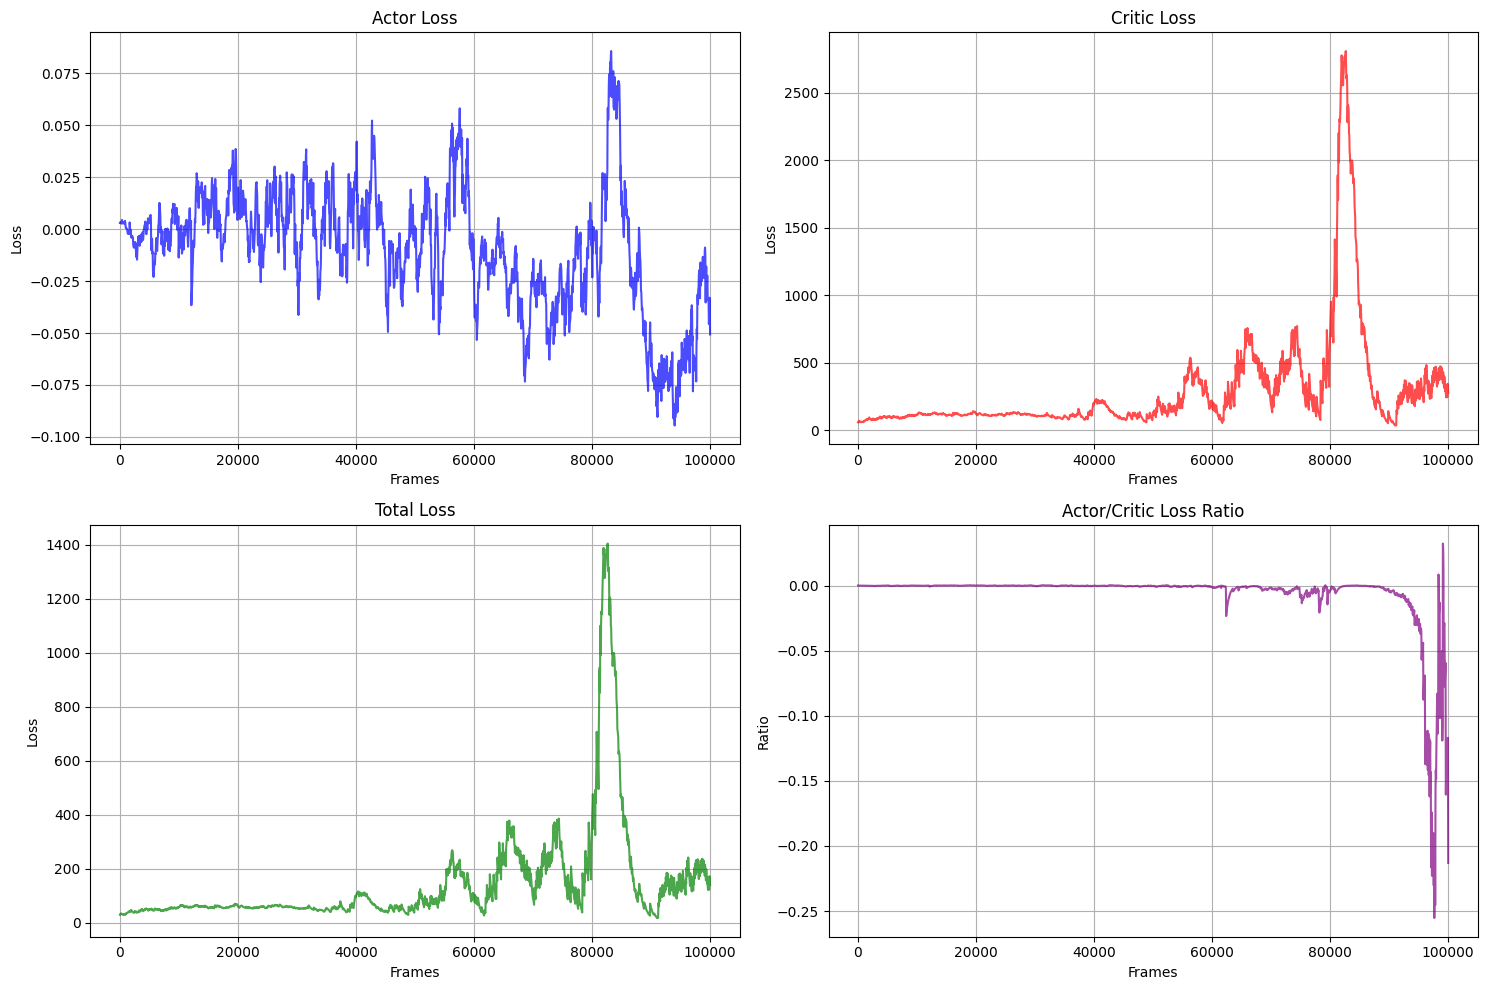

In [18]:
plot_losses_improved(frames_hist, actor_hist, critic_hist, total_hist, use_ema=True)

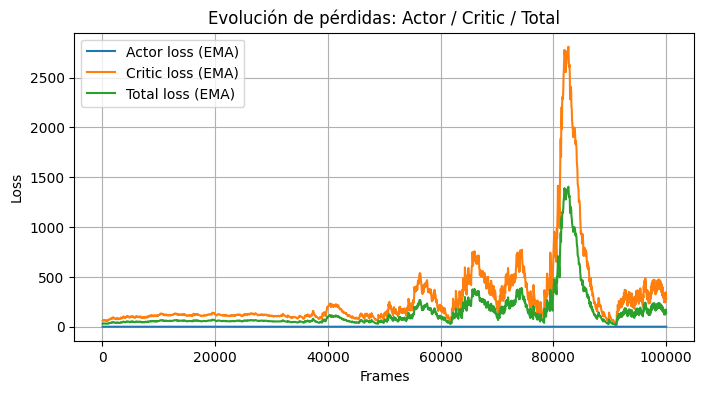

In [19]:
plot_losses(frames_hist, actor_hist, critic_hist, total_hist, use_ema=True)